<a href="https://colab.research.google.com/github/wesleiferreira98/kNN-no-Instagram/blob/main/Projeto_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import seaborn as sns
import matplotlib.pyplot as plt
import gdown

In [4]:
# URL do Google Drive
url = 'https://drive.google.com/uc?id=1MD0tpQI27v-Jmm9ZNFukUJPi0_KUn5_i'

# Caminho para salvar o arquivo temporariamente
output = '/tmp/top_insta_influencers_data.csv'

# Baixar o arquivo
gdown.download(url, output, quiet=False)

# Carregar o arquivo em um DataFrame
df = pd.read_csv(output)

# Exibindo as primeiras linhas do DataFrame para verificar
print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1MD0tpQI27v-Jmm9ZNFukUJPi0_KUn5_i
To: /tmp/top_insta_influencers_data.csv
100%|██████████| 12.6k/12.6k [00:00<00:00, 4.67MB/s]

   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%            665.3k       12.5b  United States  


# implementação dos Algoritmos 

Aqui foi implementado forma de EDA que viza fornecer uma vizão mais clara acerca dos dados da base de informações.

         country  country_numeric
0          Spain                0
1  United States                0
2            NaN                0
3  United States                0
4  United States                0


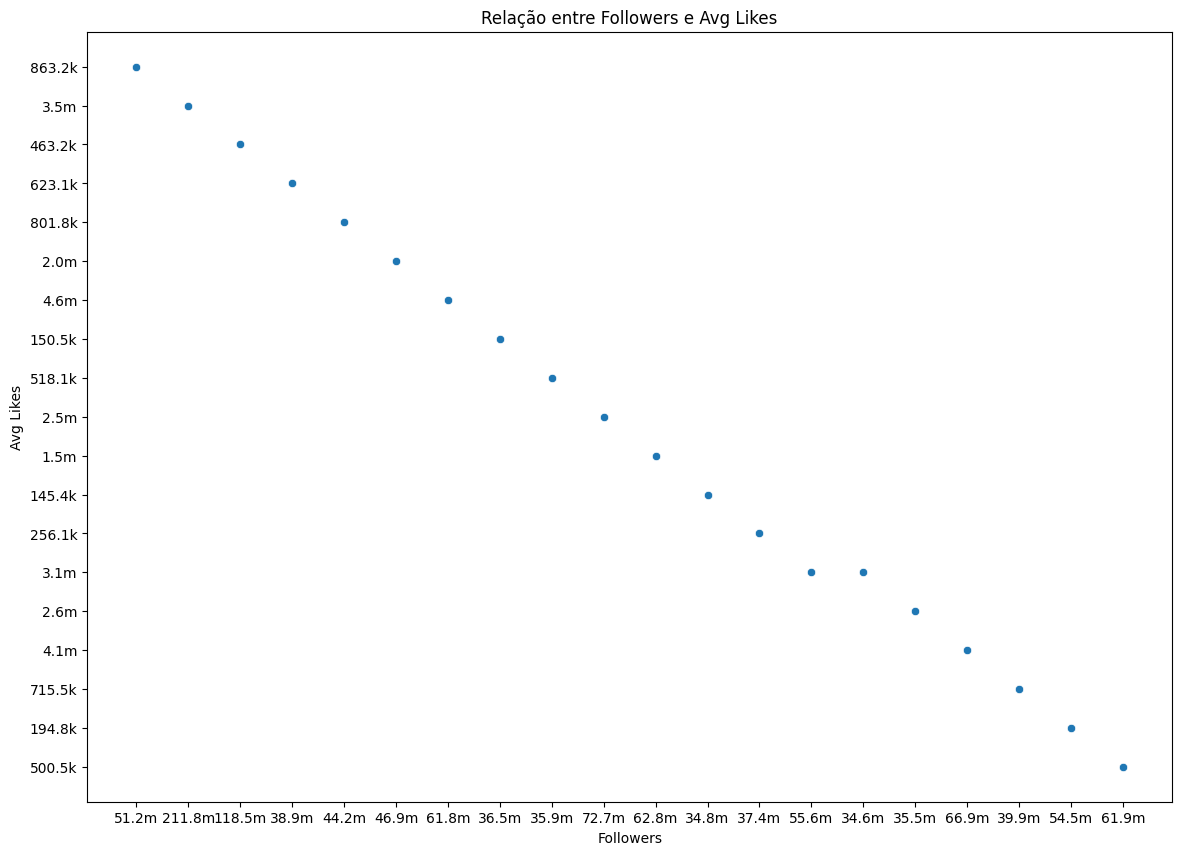

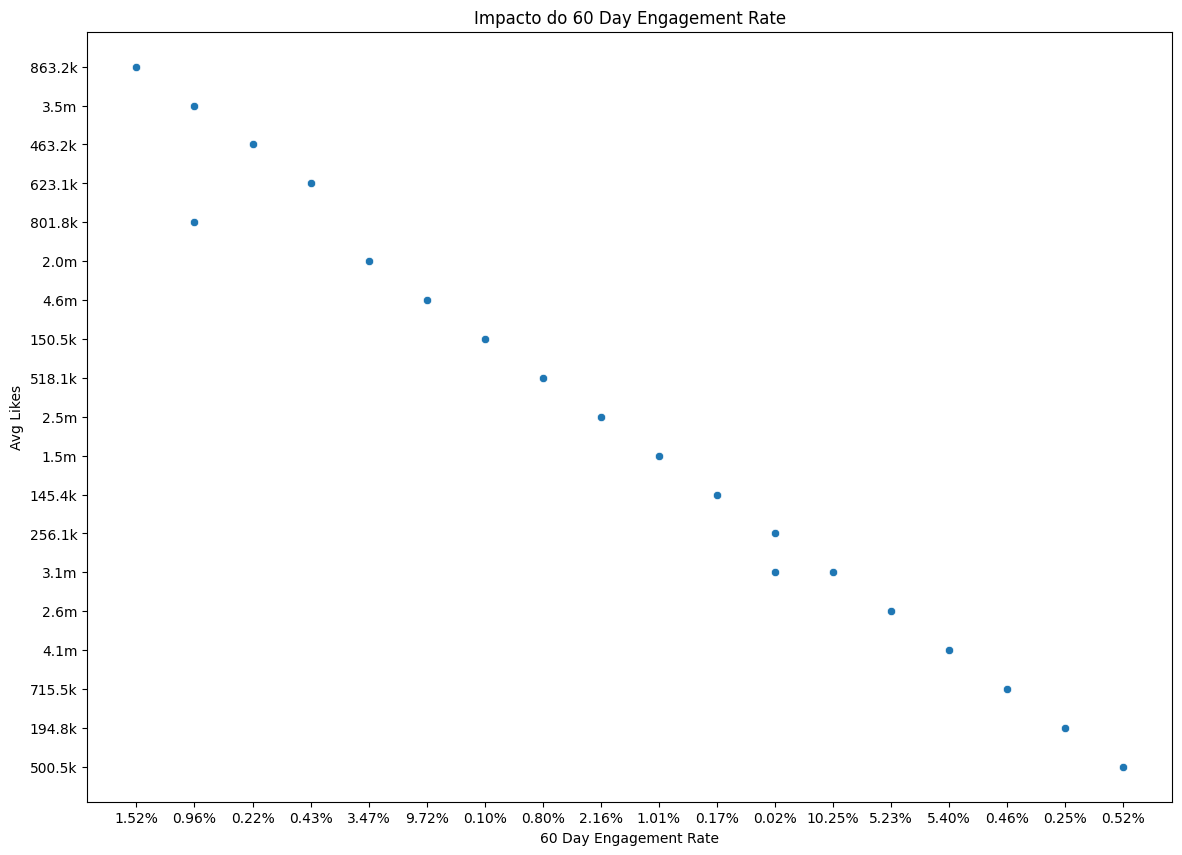

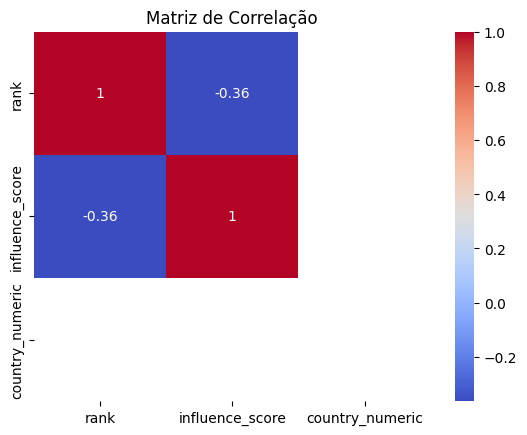

<Figure size 1400x1000 with 0 Axes>

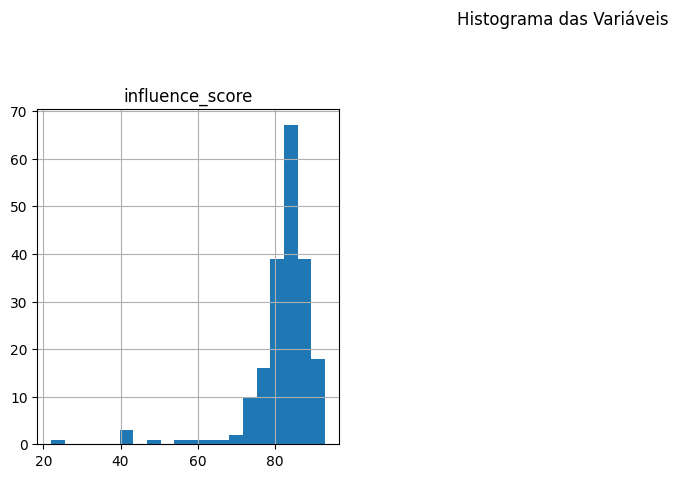

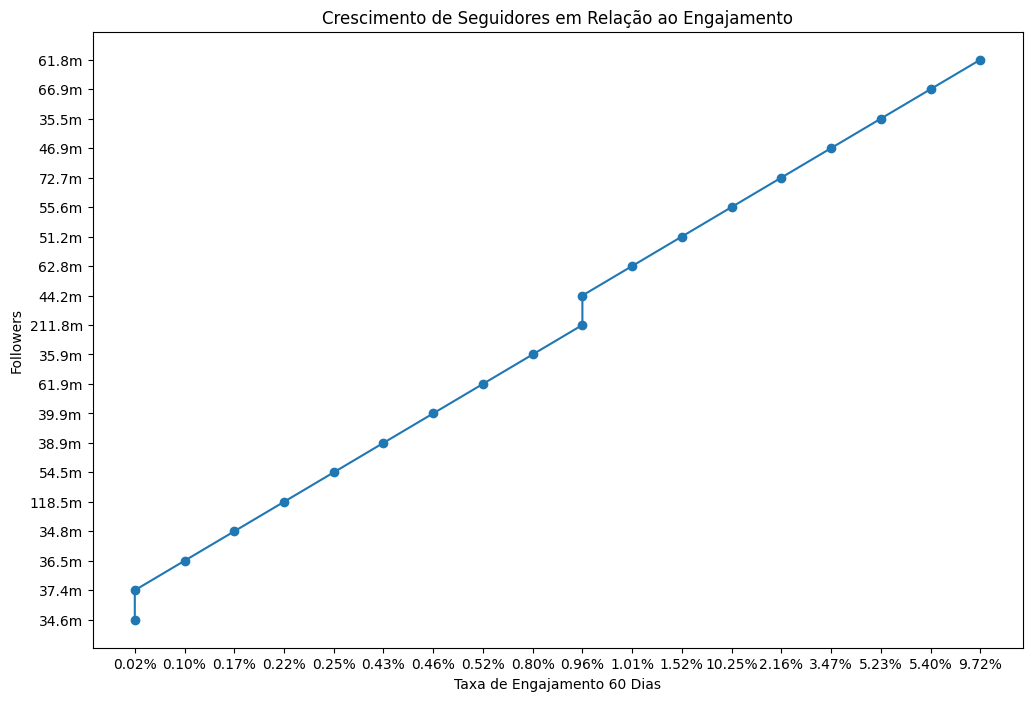

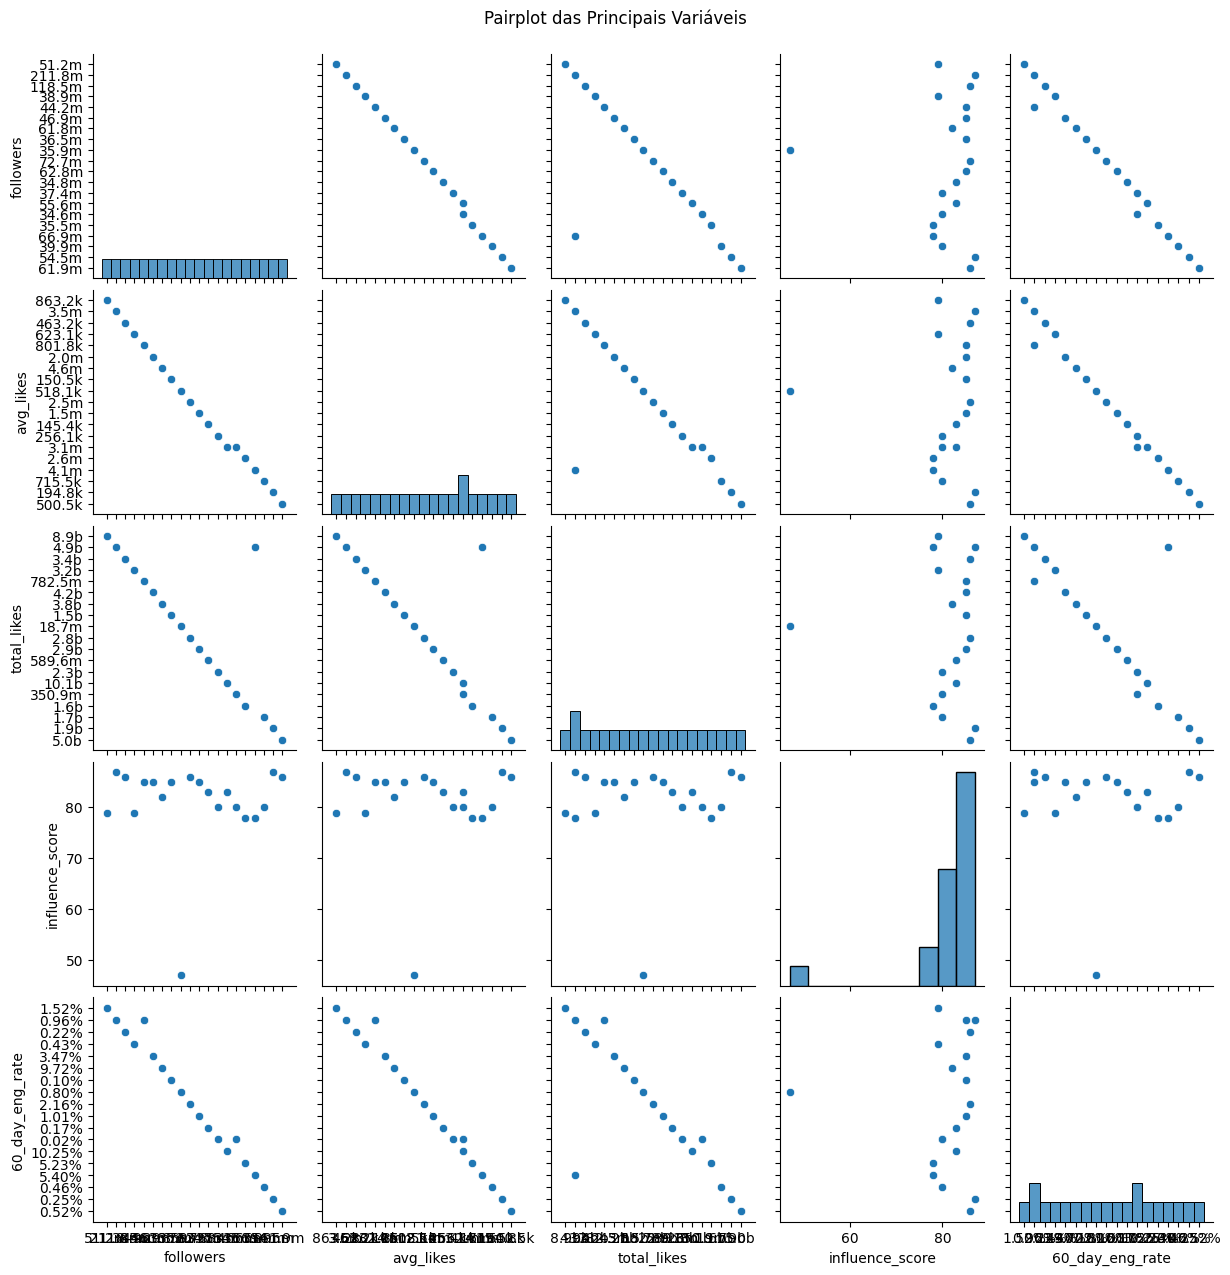

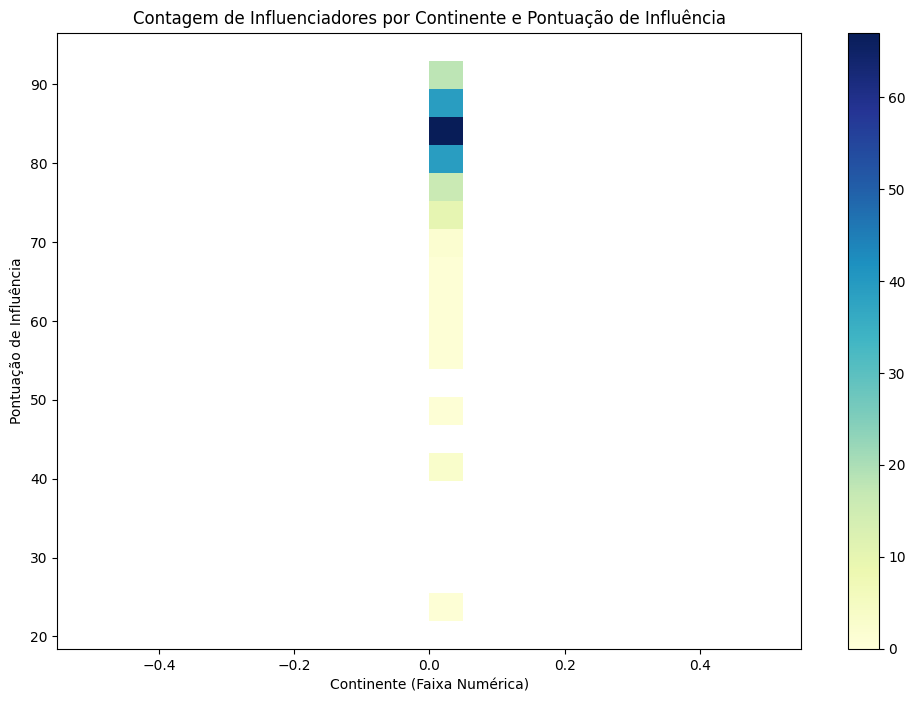

In [9]:
# Transformação de "country" em faixas numéricas por continente
continent_mapping = {
    'South America': (1, 9),
    'North America': (20, 29),
    'Europe': (40, 49),
    'Asia': (50, 59),
    'Africa': (60, 69),
    'Oceania': (70, 79)
}

# Função para mapear o país para o continente
def map_country_to_continent_range(country):
    # Verificar se o valor é nulo
    if pd.isnull(country):
        return 0  # Valor padrão para valores nulos

    # Ajustar o mapeamento com base no continente
    for continent, (start, end) in continent_mapping.items():
        if continent in country:  # Ajuste o critério conforme o necessário
            return np.random.randint(start, end + 1)
    return 0  # Valor padrão caso não encontre o país no mapeamento

# Aplicar a função
df['country_numeric'] = df['country'].apply(map_country_to_continent_range)

# Verificar a transformação
print(df[['country', 'country_numeric']].head())

sample_df = df.sample(frac=0.1,random_state=42)

# Análise Exploratória e Visualizações
plt.figure(figsize=(14,10))
sns.scatterplot(x='followers', y='avg_likes', data=sample_df)
plt.title('Relação entre Followers e Avg Likes')
plt.xlabel('Followers')
plt.ylabel('Avg Likes')
plt.show()

plt.figure(figsize=(14,10))
sns.scatterplot(x='60_day_eng_rate', y='avg_likes', data=sample_df)
plt.title('Impacto do 60 Day Engagement Rate')
plt.xlabel('60 Day Engagement Rate')
plt.ylabel('Avg Likes')
plt.show()

# Selecionar apenas colunas numéricas para a matriz de correlação
numeric_df = df.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr()

# Visualizar a matriz de correlação
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


# Histograma das variávies principais
plt.figure(figsize=(14,10))
numeric_columns = ['followers', 'avg_likes', 'total_likes', '60_day_eng_rate', 'influence_score']
df[numeric_columns].hist(bins=20, figsize=(14,10), layout=(2,3))
plt.suptitle('Histograma das Variáveis')
plt.show()

#Gráfico de Linha de Crescimento de Seguidores (Followers)
df_sorted = sample_df.sort_values('60_day_eng_rate')  # Ordenar por engajamento
plt.figure(figsize=(12, 8))
plt.plot(df_sorted['60_day_eng_rate'], df_sorted['followers'], marker='o', linestyle='-')
plt.title('Crescimento de Seguidores em Relação ao Engajamento')
plt.xlabel('Taxa de Engajamento 60 Dias')
plt.ylabel('Followers')
plt.show()


#Pairplot para Visualizar Relações Múltiplas
sns.pairplot(sample_df, vars=['followers', 'avg_likes', 'total_likes', 'influence_score', '60_day_eng_rate'])
plt.suptitle('Pairplot das Principais Variáveis', y=1.02)
plt.show()

#Mapa de Calor de Contagem de Influenciadores por Continente e Pontuação de Influência
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='country_numeric', y='influence_score', bins=20, cbar=True, cmap='YlGnBu')
plt.title('Contagem de Influenciadores por Continente e Pontuação de Influência')
plt.xlabel('Continente (Faixa Numérica)')
plt.ylabel('Pontuação de Influência')
plt.show()






#Implementação do KNN

Nessa seção dedicamos a implentação completa do KNN e no fim do treinamento as metricas MAE, MSE e RMSE são exibidas na tela.

Melhor k: 12, Melhor métrica de distância: manhattan
MAE: 5.1521739130434785, MSE: 79.20108695652176, RMSE: 8.89949925313339


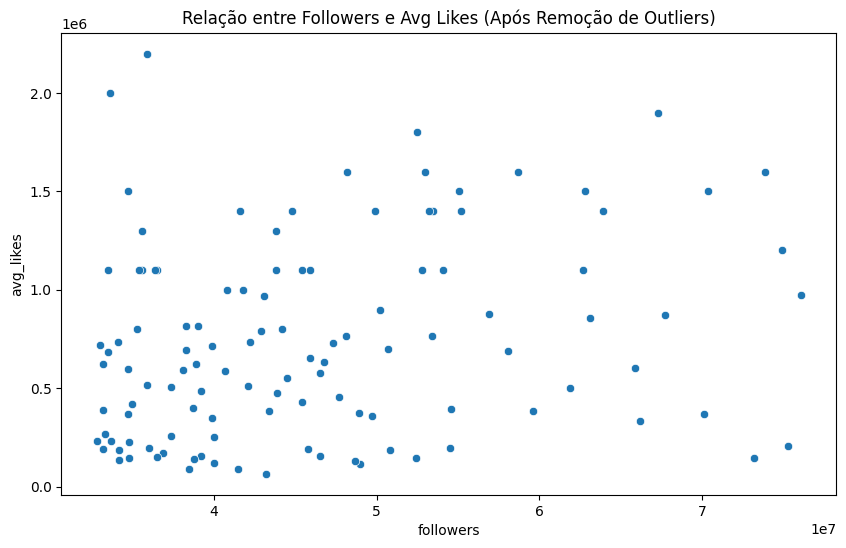

In [ ]:
def convert_to_numeric(value):
    if isinstance(value, str):
        if 'b' in value:
            return float(value.replace('b', '')) * 1_000_000_000
        elif 'm' in value:
            return float(value.replace('m', '')) * 1_000_000
        elif 'k' in value:
            return float(value.replace('k', '')) * 1_000
    return float(value)

# Aplicar a conversão nas colunas
df['followers'] = df['followers'].apply(convert_to_numeric)
df['avg_likes'] = df['avg_likes'].apply(convert_to_numeric)
df['total_likes'] = df['total_likes'].apply(convert_to_numeric)

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return float(value)

# Aplicar a conversão na coluna '60_day_eng_rate'
df['60_day_eng_rate'] = df['60_day_eng_rate'].apply(convert_percentage_to_float)
df['60_day_eng_rate'] = df['60_day_eng_rate'].astype(float)  # Garantir que está como float

# Criar nova variável de interação
df['followers_x_engagement'] = df['followers'] * df['60_day_eng_rate']

# Remover outliers nas principais variáveis numéricas
# Define os limites para cada variável usando o IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers(df, ['followers', 'avg_likes', 'total_likes', 'followers_x_engagement'])

# Selecionar as features e o target
X = df[['followers', 'avg_likes', 'total_likes', 'country_numeric', 'followers_x_engagement']]
y = df['influence_score']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados com Min-Max Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implementar o kNN
knn = KNeighborsRegressor()

# GridSearchCV para encontrar os melhores hiperparâmetros
param_grid = {'n_neighbors': [3, 5, 7, 9, 10, 12, 15, 18, 20], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Melhor modelo
best_knn = grid_search.best_estimator_
print(f"Melhor k: {grid_search.best_params_['n_neighbors']}, Melhor métrica de distância: {grid_search.best_params_['metric']}")

# Avaliar no conjunto de teste
y_pred = best_knn.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Visualização após remoção de outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='followers', y='avg_likes', data=df)
plt.title('Relação entre Followers e Avg Likes (Após Remoção de Outliers)')
plt.show()